This notebook is to show the variability of the EUV intensity in AIA images

In [134]:
import warnings
warnings.filterwarnings('ignore')
import os
import numpy as np
from sunpy.sun import constants as const
import astropy.units as u
from sunpy.net import Fido
from sunpy.net import attrs as a
from astropy.coordinates import SkyCoord
from sunpy.coordinates import Helioprojective
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import sunpy.map
from sunpy.coordinates import frames, get_body_heliographic_stonyhurst, get_horizons_coord
from matplotlib.patches import ConnectionPatch
import matplotlib
import numpy as np
import astropy.io.fits as fits
from astropy.visualization import ImageNormalize, PercentileInterval, SqrtStretch
from aiapy.calibrate import normalize_exposure, register, update_pointing

plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['savefig.facecolor'] = 'white'
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300

In [ ]:
year = '2021'
month = '09'
day = '18'

result = Fido.search(a.Time(f'{year}-{month}-{day} 00:00:00',
                            f'{year}-{month}-{day} 23:59:59'),
                     a.Instrument('AIA'),
                     a.Wavelength(193*u.angstrom),
                     a.Sample(1*u.min))

aia_files = Fido.fetch(result, path='./{instrument}/{file}')

In [ ]:
# calibrate the AIA maps


...



In [ ]:
aia_maps = []

for file in aia_files:
    m = sunpy.map.Map(file)
    aia_maps.append(m)

In [ ]:
m_seq = sunpy.map.Map(aia_maps, sequence=True)

for m in m_seq:
    m.plot_settings['norm'] = ImageNormalize(vmin=0, 
                                             vmax=3.5e3, 
                                             stretch=SqrtStretch())

In [ ]:
plt.figure(figsize=[10,10])
anim = m_seq.plot()
plt.show()

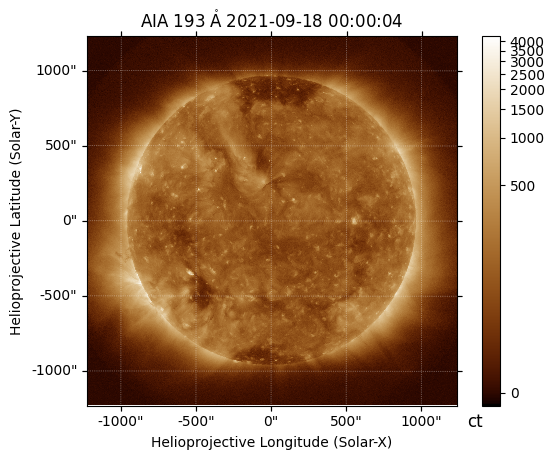

In [5]:
aia_big.peek()

In [ ]:
left_corner = SkyCoord(Tx=-320*u.arcsec, Ty=100*u.arcsec, frame=aia_big.coordinate_frame)
right_corner = SkyCoord(Tx=50*u.arcsec, Ty=500*u.arcsec, frame=aia_big.coordinate_frame)

In [ ]:
fig = plt.figure(figsize=[10,7])

ax1 = fig.add_subplot(121, projection=aia_big)
aia_big.plot(axes=ax1, clip_interval=(1, 99.99)*u.percent, annotate=True)
aia_big.draw_grid(axes=ax1, color='black', alpha=0.25, lw=0.5)
ax1.grid(b=False)

# draw the rectangle around the region we plan to showcase in the cutout image
aia_big.draw_quadrangle(left_corner, top_right=right_corner, edgecolor='black', lw=1)

#### The second stage is plotting the zoomed-in map
aia_small = aia_big.submap(left_corner, top_right=right_corner)
ax2 = fig.add_subplot(122, projection=aia_small)

# make a nice normalization range for the image
norm = aia_big.plot_settings['norm']
norm.vmin, norm.vmax = np.percentile(aia_big.data, [1, 99.99])

im = aia_small.plot(axes=ax2, norm=norm, annotate=False)
ax2.grid(alpha=0)

# clean up the axis labels and ticks
lon, lat = ax2.coords[0], ax2.coords[1]
lon.frame.set_linewidth(1)
lat.frame.set_linewidth(1)
lon.set_axislabel('Helioprojective Longitude',)
lon.set_ticks_position('b')
lat.set_axislabel('Helioprojective Latitude',)
lat.set_axislabel_position('r')
lat.set_ticks_position('r')
lat.set_ticklabel_position('r')

# we add two lines that will connect the two images as well as a colorbar
xpix, ypix = aia_big.world_to_pixel(right_corner)
con1 = ConnectionPatch(
    (0,1), (xpix.value, ypix.value), 'axes fraction', 'data', axesA=ax2, axesB=ax1, 
    arrowstyle='-', color='black', lw=1)

xpix, ypix = aia_big.world_to_pixel(SkyCoord(right_corner.Tx, left_corner.Ty, frame=aia_big.coordinate_frame))
con2 = ConnectionPatch(
    (0,0), (xpix.value, ypix.value), 'axes fraction', 'data', axesA=ax2, axesB=ax1, 
    arrowstyle='-', color='black', lw=1)

ax2.add_artist(con1)
ax2.add_artist(con2)
# fig.savefig(f'{basedir_lof}/plots/aia_cutout.png', dpi=300, format='png', bbox_inches='tight')
# fig.savefig(f'{basedir_lof}/plots/aia_cutout.pdf', format='pdf', bbox_inches='tight')
plt.show()

The example uses the `RotatedSunFrame` coordinate metaframe in `sunpy.coordinates` to apply differential rotation to a coordinate.

In [42]:
import matplotlib.pyplot as plt
import numpy as np

import astropy.units as u
from astropy.coordinates import SkyCoord

import sunpy.map
from sunpy.coordinates import RotatedSunFrame
from sunpy.data.sample import AIA_171_IMAGE

First, load an AIA observation and define a coordinate in its coordinate frame (here, helioprojective Cartesian). The appropriate rate of rotation is determined from the heliographic latitude of the coordinate.

In [43]:
aiamap = sunpy.map.Map(AIA_171_IMAGE)
point = SkyCoord(187*u.arcsec, 283*u.arcsec, frame=aiamap.coordinate_frame)

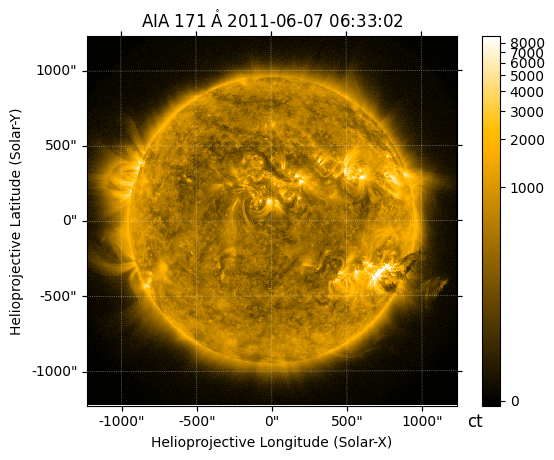

In [58]:
aiamap.peek(clip_interval=(1, 99.95)*u.percent)

We can differentially rotate this coordinate by using `RotatedSunFrame` with an array of observation times. Let’s define a daily cadence for +/- five days.

In [48]:
durations = np.concatenate([range(-5, 0), range(1, 6)])*u.day
diffrot_point = SkyCoord(RotatedSunFrame(base=point, duration=durations))

To see what this coordinate looks like in “real” helioprojective Cartesian coordinates, we can transform it back to the original frame. Since these coordinates are represented in the original frame, they will not account for the changing position of the observer over this same time range.

In [ ]:
transformed_diffrot_point = diffrot_point.transform_to(aiamap.coordinate_frame)

Let’s plot the original coordinate and the differentially rotated coordinates on top of the AIA observation.

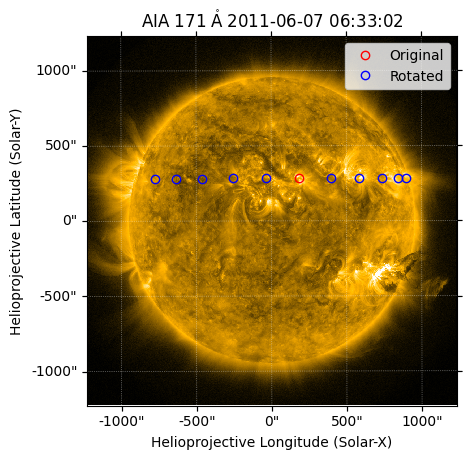

In [49]:
fig = plt.figure()
ax = fig.add_subplot(projection=aiamap)
aiamap.plot(axes=ax, clip_interval=(1, 99.95)*u.percent)
ax.plot_coord(point, 'ro', fillstyle='none', label='Original')
ax.plot_coord(transformed_diffrot_point, 'bo', fillstyle='none', label='Rotated')
ax.legend()
plt.show()

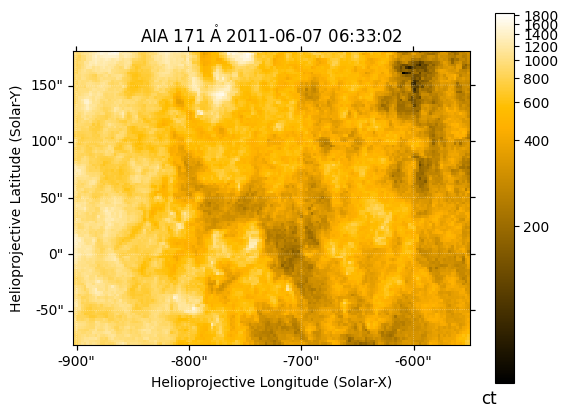

In [64]:
# rotate a submap instead of a point
top_right = SkyCoord(-550*u.arcsec, 180*u.arcsec, frame=aiamap.coordinate_frame)
bottom_left = SkyCoord(-900*u.arcsec, -80*u.arcsec, frame=aiamap.coordinate_frame)

aia_sub = aiamap.submap(bottom_left, top_right=top_right)
aia_sub.peek()

In [81]:
durations = np.concatenate([range(-5, 0), range(1, 6)])*u.day

diffrot_point_topRight = SkyCoord(RotatedSunFrame(base=top_right, duration=durations))
diffrot_point_bottomLeft = SkyCoord(RotatedSunFrame(base=bottom_left, duration=durations))

transformed_diffrot_point_topRight = diffrot_point_topRight.transform_to(aiamap.coordinate_frame)
transformed_diffrot_point_bottomLeft = diffrot_point_bottomLeft.transform_to(aiamap.coordinate_frame)

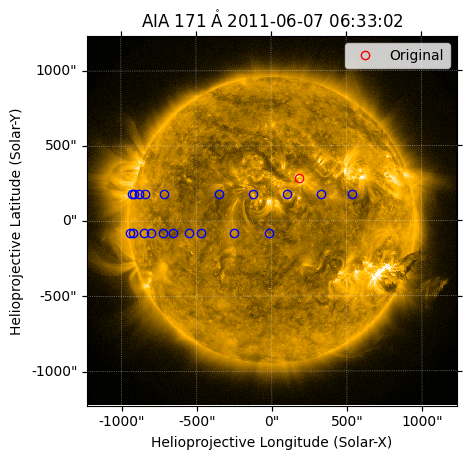

In [83]:
fig = plt.figure()
ax = fig.add_subplot(projection=aiamap)
aiamap.plot(axes=ax, clip_interval=(1, 99.95)*u.percent)
ax.plot_coord(point, 'ro', fillstyle='none', label='Original')
ax.plot_coord(transformed_diffrot_point_topRight, 'bo', fillstyle='none')
ax.plot_coord(transformed_diffrot_point_bottomLeft, 'bo', fillstyle='none')
ax.legend()
plt.show()

Doing it manually

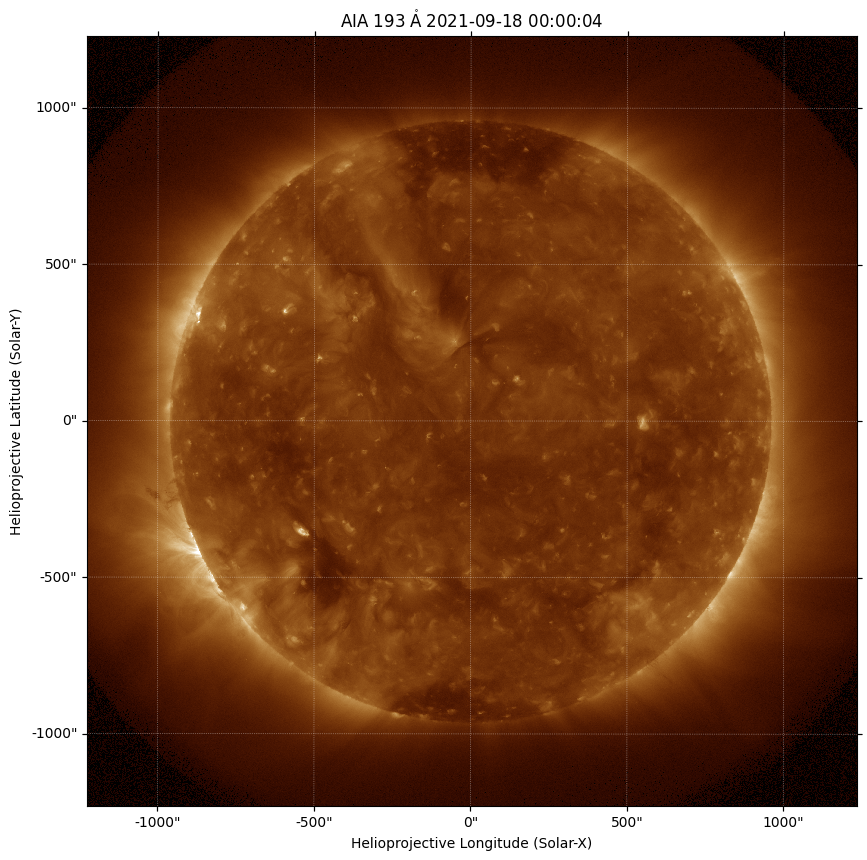

In [94]:
aia_map = sunpy.map.Map(aia_files.data[0])
aia_map.plot_settings['norm'] = ImageNormalize(vmin=0, vmax=3e3, stretch=SqrtStretch())
plt.figure(figsize=[10,10])
aia_map.plot()

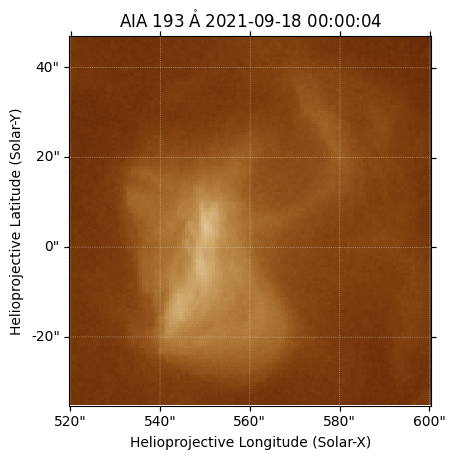

In [103]:
left_corner = SkyCoord(Tx=520*u.arcsec, Ty=47*u.arcsec, frame=aia_map.coordinate_frame)
right_corner = SkyCoord(Tx=600*u.arcsec, Ty=-35*u.arcsec, frame=aia_map.coordinate_frame)

aia_sub = aia_map.submap(left_corner, top_right=right_corner)
aia_sub.plot()

In [106]:
# average intensity in the submap
np.nanmean(aia_sub.data)

290.6110142717072

Doing it in a Loop

In [ ]:
avg_int = []




# average intensity in the submap

avg_int.append(np.nanmean(aia_sub.data))

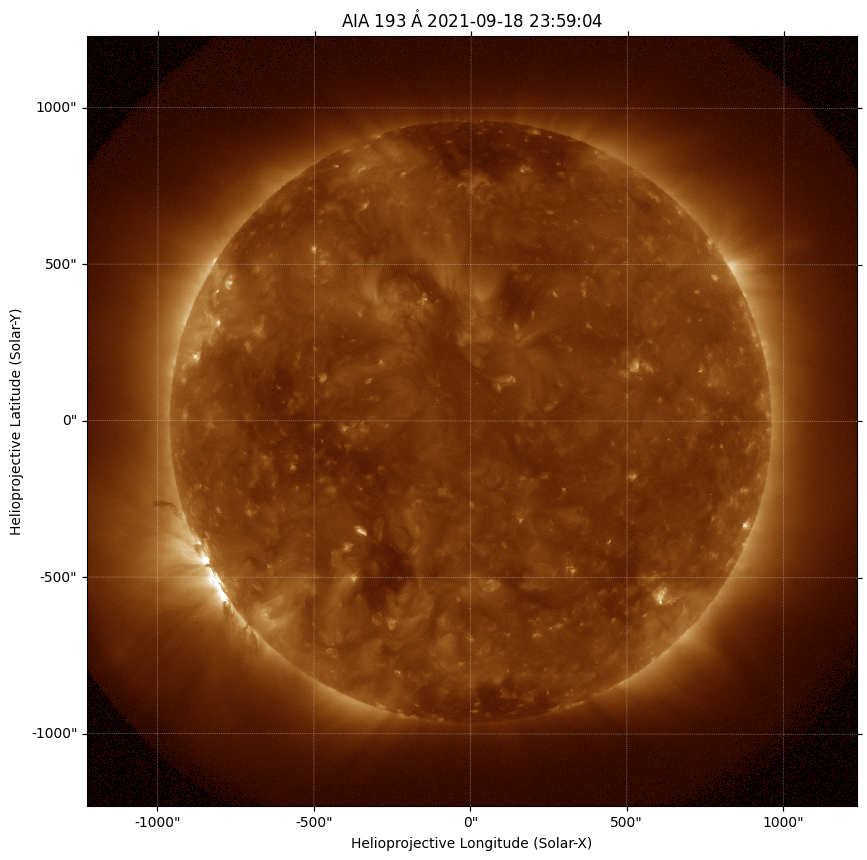

In [107]:
aia_map = sunpy.map.Map(aia_files.data[-1])
aia_map.plot_settings['norm'] = ImageNormalize(vmin=0, vmax=3e3, stretch=SqrtStretch())
plt.figure(figsize=[10,10])
aia_map.plot()

In [ ]:
# calibrate AIA maps to level 1.5
for file in aia_files.data:
    m = sunpy.map.Map(file)
    m_updated_pointing = update_pointing(m)
    m_registered = register(m_updated_pointing)
    m_normalized = normalize_exposure(m_registered)
    
    plt.figure(figsize=[7,7])
    m_normalized.plot(vmin=0)
    plt.savefig(f"./plots/aia_maps/{file.split('/')[1].split('.')[0][:-5]}.png", format='png')
    plt.close()

### Start from here ...

In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
import glob
import numpy as np
import pandas as pd
from sunpy.sun import constants as const
import astropy.units as u
from sunpy.net import Fido
from sunpy.net import attrs as a
from astropy.coordinates import SkyCoord
from sunpy.coordinates import Helioprojective
import matplotlib.pyplot as plt
import sunpy.map
from sunpy.coordinates import RotatedSunFrame
from sunpy.coordinates import frames, get_body_heliographic_stonyhurst, get_horizons_coord
from matplotlib.patches import ConnectionPatch
import matplotlib
import numpy as np
import astropy.io.fits as fits
from astropy.visualization import ImageNormalize, PercentileInterval, SqrtStretch
from aiapy.calibrate import normalize_exposure, register, update_pointing

plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['savefig.facecolor'] = 'white'
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300

In [ ]:
year = '2021'
month = '09'
day = '18'
channel = 211

# Download AIA data
result = Fido.search(a.Time(f'{year}-{month}-{day} 00:00',
                            f'{year}-{month}-{day} 23:59'),
                    a.Instrument('AIA'),
                    a.Wavelength(channel*u.angstrom),
                    a.Sample(1*u.min))

aia_files = Fido.fetch(result, path='./{instrument}/{file}')
len(aia_files)

In [184]:
# Load AIA data
aia_files = sorted(glob.glob(f'./AIA/*{channel}*_{year}_{month}_{day}*.fits'))
print(len(aia_files))

1439


Mean intensity at that bright spot is: 146.61353605096267 DN.


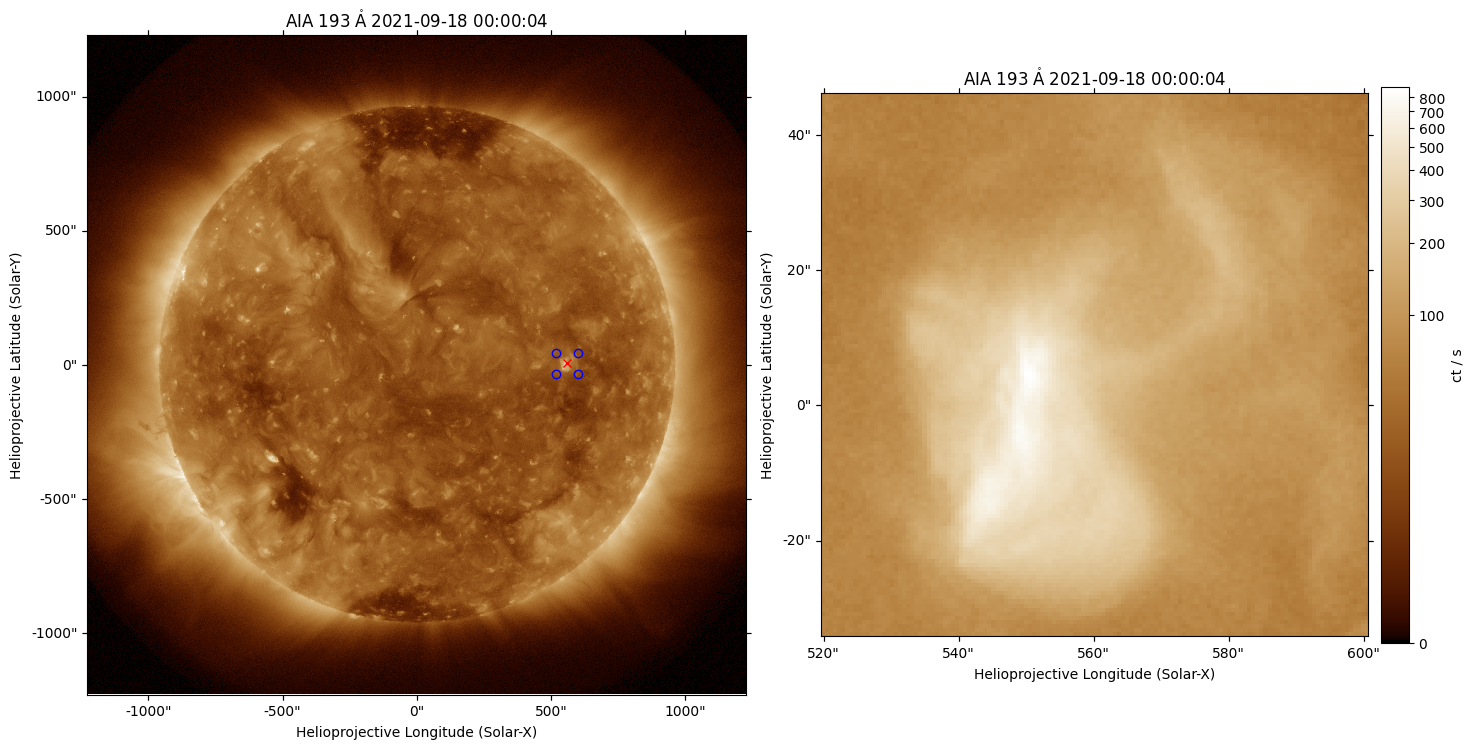

In [116]:
# store all the mean intensities of the region of interest
list_mean_int = []

# load and calibrate the map
aiamap = sunpy.map.Map(aia_files[0])
aiamap_updated_pointing = update_pointing(aiamap)
aiamap_registered = register(aiamap_updated_pointing)
aiamap_normalized = normalize_exposure(aiamap_registered)

# We can differentially rotate this coordinate by using `RotatedSunFrame` with an array of observation times. Let’s define a daily cadence for +/- five days.
center_point = SkyCoord(560*u.arcsec, 6*u.arcsec, frame=aiamap_normalized.coordinate_frame)
increment = 40*u.arcsec
duration = range(1, len(aia_files), 1)*u.minute

top_left  = SkyCoord(center_point.Tx - increment, center_point.Ty + increment, frame=aiamap_normalized.coordinate_frame)
top_right = SkyCoord(center_point.Tx + increment, center_point.Ty + increment, frame=aiamap_normalized.coordinate_frame)

bottom_left  = SkyCoord(center_point.Tx - increment, center_point.Ty - increment, frame=aiamap_normalized.coordinate_frame)
bottom_right = SkyCoord(center_point.Tx + increment, center_point.Ty - increment, frame=aiamap_normalized.coordinate_frame)

diffrot_center_point = SkyCoord(RotatedSunFrame(base=center_point, duration=duration))

diffrot_topleft_point  = SkyCoord(RotatedSunFrame(base=top_left, duration=duration))
diffrot_topright_point = SkyCoord(RotatedSunFrame(base=top_right, duration=duration))

diffrot_bottomleft_point  = SkyCoord(RotatedSunFrame(base=bottom_left, duration=duration))
diffrot_bottomright_point = SkyCoord(RotatedSunFrame(base=bottom_right, duration=duration))

# plot the map with the points
fig = plt.figure(figsize=[15,10])
ax = fig.add_subplot(121, projection=aiamap_normalized)
aiamap_normalized.plot(axes=ax, vmin=0)
ax.grid(b=False)

ax.plot_coord(center_point, 'rx', fillstyle='none')
ax.plot_coord(top_left, 'bo', fillstyle='none')
ax.plot_coord(top_right, 'bo', fillstyle='none')
ax.plot_coord(bottom_left, 'bo', fillstyle='none')
ax.plot_coord(bottom_right, 'bo', fillstyle='none')

# rotate a submap instead of a point
aia_sub = aiamap_normalized.submap(bottom_left, top_right=top_right)
ax = fig.add_subplot(122, projection=aia_sub)
im = aia_sub.plot(axes=ax, vmin=0)
plt.colorbar(im, shrink=0.6, pad=0.02, label=aia_sub.meta['bunit'])
ax.grid(b=False)
fig.tight_layout()

image_path = f"./plots/aia_maps/{aia_files[0].split('/')[-1][4:-10]}.png"
if not os.path.exists(image_path):
    fig.savefig(image_path, format='png', dpi=100, bbox_inches='tight')

mean_int = np.nanmean(aia_sub.data)
obs_time = aia_sub.meta['date-obs'].replace('T', ' ')
list_mean_int.append((obs_time, mean_int))

print(f"Mean intensity at that bright spot is: {mean_int} {aiamap.meta['pixlunit']}.")
plt.show()

In [117]:
list_mean_int

[('2021-09-18 00:00:04.84', 146.61353605096267)]

In [ ]:
# Run the above in a for loop over all the AIA maps for the day to track the bright spot
# I have to run the loop in batches because I run on my local computer!
start_index = 1
end_index = 500

for i, map in enumerate(aia_files[start_index:end_index]):

    # load and calibrate the map
    aiamap = sunpy.map.Map(map)
    aiamap_updated_pointing = update_pointing(aiamap)
    aiamap_registered = register(aiamap_updated_pointing)
    aiamap_normalized = normalize_exposure(aiamap_registered)

    print(f'Working on file number: {start_index + i}')
    print(f"{aiamap_normalized.meta['date-obs'].replace('T', ' ')}\n")

    # plot the map with the rotated points
    fig = plt.figure(figsize=[15,10])
    ax = fig.add_subplot(121, projection=aiamap_normalized)
    aiamap_normalized.plot(axes=ax, vmin=0)
    ax.grid(b=False)

    ax.plot_coord(diffrot_center_point[start_index + i], 'rx', fillstyle='none')
    ax.plot_coord(diffrot_topleft_point[start_index + i], 'bo', fillstyle='none')
    ax.plot_coord(diffrot_topright_point[start_index + i], 'bo', fillstyle='none')
    ax.plot_coord(diffrot_bottomleft_point[start_index + i], 'bo', fillstyle='none')
    ax.plot_coord(diffrot_bottomright_point[start_index + i], 'bo', fillstyle='none')

    # rotate the submap
    aia_sub = aiamap_normalized.submap(diffrot_bottomleft_point[start_index + i], top_right=diffrot_topright_point[start_index + i])

    ax = fig.add_subplot(122, projection=aia_sub)
    im = aia_sub.plot(axes=ax, vmin=0)
    plt.colorbar(im, shrink=0.6, pad=0.02, label=aia_sub.meta['bunit'])
    ax.grid(b=False)
    fig.tight_layout()

    image_path = f"./plots/aia_maps/{map.split('/')[-1][4:-10]}.png"
    if not os.path.exists(image_path):
        fig.savefig(image_path, format='png', dpi=100, bbox_inches='tight')
    
    mean_int = np.nanmean(aia_sub.data)
    obs_time = aia_sub.meta['date-obs'].replace('T', ' ')
    list_mean_int.append((obs_time, mean_int))
    
    plt.close()

In [115]:
df = pd.DataFrame(list_mean_int)
df.to_csv(f'./mean_intensities.csv')
print('Table exported successfully!')

1439

In [189]:
df193 = pd.read_csv('/home/mnedal/DIAS/mean_intensities_193a.csv', names=['Datetime','avg_int'], index_col=0, skiprows=[0])
df193['Datetime'] = pd.to_datetime(df193['Datetime'])
df193.set_index('Datetime', inplace=True)

df211 = pd.read_csv('/home/mnedal/DIAS/mean_intensities_211a.csv', names=['Datetime','avg_int'], index_col=0, skiprows=[0])
df211['Datetime'] = pd.to_datetime(df211['Datetime'])
df211.set_index('Datetime', inplace=True)

In [196]:
len(df193), len(df211)

(1440, 1439)

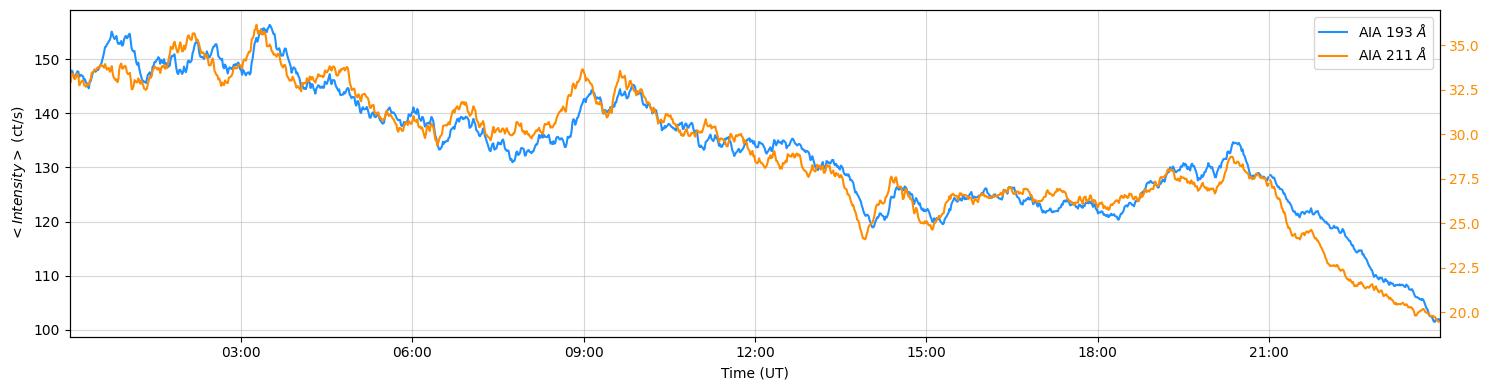

In [207]:
fig = plt.figure(figsize=[15,4])
ax = fig.add_subplot(111)
ax.plot(df193.index, df193['avg_int'], color='dodgerblue', label=r'AIA 193 $\AA$')

ax1 = ax.twinx()
ax1.plot(df211.index, df211['avg_int'], color='darkorange', label=r'AIA 211 $\AA$')

# Change color of ticks and numbers on the right y-axis
ax1.tick_params(axis='y', colors='darkorange')

ax.set_xlabel('Time (UT)')
ax.set_ylabel(r'$<Intensity>$ (ct/s)')
# ax.set_title('')
# ax.set_yscale('log')
ax.grid(alpha=0.5)
ax.xaxis_date()
ax.xaxis.set_major_formatter(DateFormatter('%H:%M'))
ax.set_xlim(df193.index[0], df193.index[-1])

# Combine legends into one box
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax1.get_legend_handles_labels()
ax.legend(lines + lines2, labels + labels2, loc='upper right')

fig.tight_layout()
fig.savefig('./aia_mean_int.png', format='png', dpi=300, bbox_inches='tight')
plt.show()

In [185]:
# Export a movie from saved images
year = '2021'
month = '09'
day = '18'
channel = 211

aia_images = sorted(glob.glob(f'/home/mnedal/DIAS/plots/aia_maps/lev1_{channel}*_{year}_{month}_{day}*.png'))
len(aia_images)

1439

In [3]:
import cv2
import glob

def images_to_video(image_paths, video_name, fps=24):
    frame = cv2.imread(image_paths[0])
    height, width, layers = frame.shape
    video = cv2.VideoWriter(video_name, cv2.VideoWriter_fourcc(*'mp4v'), fps, (width, height))
    for image_path in image_paths:
        video.write(cv2.imread(image_path))
    cv2.destroyAllWindows()
    video.release()

# images_to_video(aia_images, f'./output_aia{channel}_{year}{month}{day}.mp4')

In [4]:
# Export a movie from saved images
year = '2021'
month = '09'
day = '18'

images = sorted(glob.glob(f'/home/mnedal/DIAS/plots/monitor/monitor_*{year}-{month}-{day}*.png'))
print(len(images))

images_to_video(images, f'/HDD/mnedal/output_monitor_{year}{month}{day}.mp4')

867